# Gestion de Datos

Para contemplar el universo de probabilidades y compararlo con los resultados optimizados, se ha realizado una simulación de Monte Carlo.

In [104]:
n_samples = 10000

In [105]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def plot_sharpe(returns, mask=None, best=None):
    # Generamos los pesos aleatoriamente
    n_assets = len(returns.iloc[0])
    mask = np.ones(n_assets) if mask is None else mask

    generator = np.random.default_rng(42)
    weights = generator.random(size=(n_samples, n_assets))
    weights = (mask * weights) / np.sum(weights, axis=1, keepdims=True)

    daily_returns = returns @ weights.T
    daily_returns_std = daily_returns.std(axis=0)
    daily_returns_mean = daily_returns.mean(axis=0)

    plt.scatter(x=daily_returns_std, y=daily_returns_mean, c=daily_returns_mean/daily_returns_std, marker="o", cmap="coolwarm")

    if best is not None:
        plt.scatter(best['x'], best['y'], color='red', marker='*', s=300)

    plt.grid(True)
    plt.xlabel("Riesgo (std)")
    plt.ylabel("Retorno esperado")
    plt.title("Retorno vs. Riesgo de carteras aleatorias")
    plt.show()

In [106]:
def get_data(csv=True):
    if csv:
        return pd.read_csv('resources/prod_long_sharpe_u50_20260116_v5_train_dataset.csv')
    else:

        tickers = [
          # --- Extrema Volatilidad & Cripto-Proxies ---
          'MSTR', 'MARA', 'RIOT', 'CLSK', 'COIN', 'CAN', 'WULF',

          # --- ETFs Apalancados (Varianza Extrema) ---
          'TQQQ', 'SOXL', 'UPRO', 'LABU', 'FNGU', 'YINN', 'BOIL', 'UVIX', 'TMF',

          # --- Tech Agresiva & Memes ---
          'TSLA', 'GME', 'AMC', 'PLTR', 'SNOW', 'U', 'PATH', 'AI', 'UPST',
          'CVNA', 'DKNG', 'HOOD', 'PYPL', 'RIVN', 'LCID', 'NIO',

          # --- Biotecnología (Gaps de precio) ---
          'MRNA', 'BNTX', 'SAVA', 'VKTX', 'CRSP', 'ILMN',

          # --- Commodities & Energía Volátil ---
          'XOP', 'UNG', 'XME', 'GDXJ', 'FCX', 'SQM', 'ALB',

          # --- China & Emergentes (Riesgo Político) ---
          'BABA', 'JD', 'PDD', 'KWEB',

          # --- Refugios (Para probar la lógica de asignación) ---
          'SHV', 'BIL'
        ]

        # Descarga de datos (2 años para tener historial suficiente)
        return yf.download(tickers, period="2y", interval="1d")['Close'].pct_change().dropna()

In [107]:

returns = get_data(csv=False)
if not len(returns):
    exit(-1)

plot_sharpe(returns)


[*********************100%***********************]  51 of 51 completed

7 Failed downloads:
['SOXL', 'SQM', 'TMF', 'GME', 'UVIX', 'HOOD', 'RIOT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
/var/folders/k4/y7yhj5h91ws_nh7yxjg8p32w0000gn/T/ipykernel_8393/460728574.py:31: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return yf.download(tickers, period="2y", interval="1d")['Close'].pct_change().dropna()


IndexError: single positional indexer is out-of-bounds

Ahora que sabemos que aspecto tiene, vamos a filtrar los activos que tengan una correlación alta, para diversificar la cartera correctamente y reducir la volatilidad (si dos activos con una correlación alta sufren una caída del precio, esto condiciona nuestro ratio de sharpe).
Tambien calculamos la curtosis y eliminamos aquellos que tienen una curtosis muy alta

Mirar asimetrias tambien, queremos una cartera poco volatil y que nos permita maximizar el rendimiento sin sustos

{'asset39', 'asset18', 'asset16', 'asset1', 'asset8', 'asset20', 'asset40', 'asset21', 'asset22', 'asset27', 'asset14', 'asset41', 'asset2', 'asset42', 'asset34', 'asset15'}
[38, 17, 15, 0, 7, 19, 39, 20, 21, 26, 13, 40, 1, 41, 33, 14]


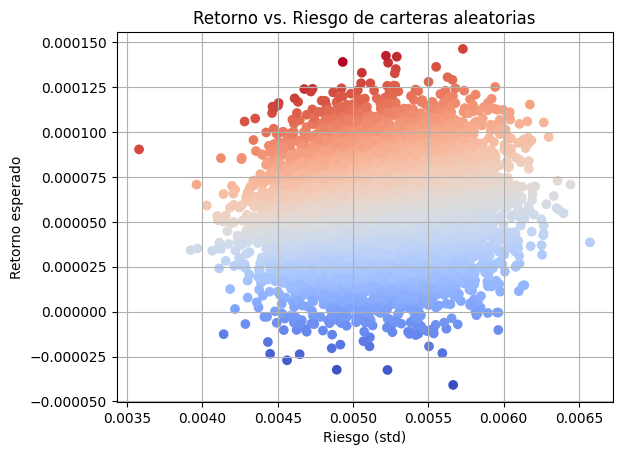

In [ ]:
sharpe = returns.mean() / returns.std()

drop = set()

# Curtosis
kurtosis = returns.kurtosis()
for asset, _ in returns.items():
    if (kurtosis[asset] > 6):
        drop.add(asset)

# Obtenemos la correlacion absoluta
correlations = returns.corr().abs()
correlated = correlations[(correlations >= 0.8) & (correlations < 1)].stack()

for (a, b), _ in correlated.items():
    if a in drop or b in drop:
        continue
    if sharpe[a] > sharpe[b]:
        drop.add(b)
    else:
        drop.add(a)


drop_indexes = [returns.columns.get_loc(col) for col in drop]

print(drop)
print(drop_indexes)

mask = np.ones(len(returns.iloc[0]))
mask[drop_indexes] = 0

plot_sharpe(returns, mask)

Lo que usabamos antes:


´´
daily_returns = returns @ weights.T
daily_returns_std = daily_returns.std(axis=0)
daily_returns_mean = daily_returns.mean(axis=0)
Objective -> daily_returns_mean/daily_returns_std

No vale porque no es convexo



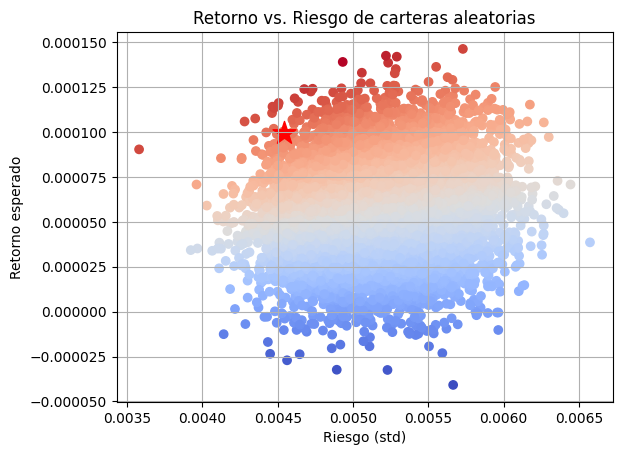

In [ ]:
import cvxpy as cp

# Los assets con correlacion inferior al 80% y curtosis <= 6 y el activo de renta fija
n_assets = len(returns.iloc[0]) + 1

returns_cov = returns.cov()
# 2% se refiere a anual
fixed_income_return = 0.02 / 252 
returns_means = returns.mean(axis=0).values
returns_means = np.append(returns_means, (fixed_income_return)) 

min_expected_ret_daily = returns_means.min()
max_expected_ret_daily = returns_means.max() * 0.6

# CVXPY
best_weights = cp.Variable(n_assets)
portfolio_returns = returns_means @ best_weights
# La renta fija no afecta a la varianza (riesgo 0)
portfolio_variance = cp.quad_form(best_weights[:-1], returns_cov)

constraints = [
    cp.sum(best_weights) == 1, # Todo el capital debe estar invertido
    best_weights[:-1] <= 0.1, # No invertimos mas de un 10% en cada activo
    best_weights[-1] <= 0.1, # El activo de renta fija debe pesar como mucho un 10%
    best_weights >= 0, # No se permiten posiciones cortas
    best_weights[drop_indexes] == 0, # Evitamos dar peso a los activos muy relacionados o con curtosis alta
    best_weights @ returns_means >= fixed_income_return # Exigimos un minimo de 2% de rentabilidad anualizada (lo que nos da la renta fija)
]

problem = cp.Problem(cp.Minimize(portfolio_variance), constraints)
problem.solve()

if best_weights.value is not None:
    ret = portfolio_returns.value
    vol = np.sqrt(portfolio_variance.value)
    sharpe_ratio = ret / vol if vol > 0 else 0
    row = np.concatenate([[ret], [vol], [sharpe_ratio], best_weights.value])

columns = ["return", "volatility", "sharpe"] + [f"asset{i}" for i in range(n_assets - 1)] + ["Renta Fija"]
portfolio_results = pd.DataFrame([row], columns=columns)
portfolio_results = portfolio_results.sort_values(by="sharpe", ascending=False)

best_sharpe = portfolio_results.iloc[0]
best_sharpe_weights = best_sharpe[3:]

plot_sharpe(returns, mask, best={'x': best_sharpe['volatility'], 'y': best_sharpe['return']})


In [ ]:
# Esta funcion ha sido desarrollada por Gemini 3 en su totalidad, se ha limpiado para adaptarla a
def round_weights(weights, decimals=3):

    rounded_weights = np.floor(np.array(weights) * (10**decimals)) / (10**decimals)
    rounded_weights[rounded_weights < 0] = 0
    diff = round(1.0 - np.sum(rounded_weights), decimals)
    priority_idxs = np.argsort(weights)[::-1]
    step = 1 / (10**decimals)

    i = 0
    while diff > 0:
        i += 1
        diff = round(diff - step, decimals)
        idx = priority_idxs[i % len(priority_idxs)]
        rounded_weights[idx] = round(rounded_weights[idx] + step, decimals)

    return rounded_weights

In [ ]:
rounded_weights = round_weights(best_sharpe_weights.tolist())
pesos_limpios = [f"{p:g}" for p in rounded_weights]
print(pesos_limpios)
print(len(rounded_weights[rounded_weights > 0]))

['0', '0', '0.001', '0.011', '0.1', '0.1', '0', '0', '0', '0', '0.087', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0.1', '0', '0.027', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0.08', '0.017', '0.03', '0', '0', '0', '0', '0', '0', '0.005', '0.1', '0.087', '0', '0', '0.055', '0.1', '0.1']
16


In [ ]:
# Sortino (Gemini 3)

# 1. Calculamos el retorno diario histórico de la cartera
portfolio_daily_returns = returns.values @ np.array(rounded_weights[:-1])

# 2. Definimos el umbral (Tasa libre de riesgo diaria)
rf_diaria = 0.02/252

# 3. Filtramos solo los retornos que fueron menores que la RF
excess_returns = portfolio_daily_returns - rf_diaria
downside_diff = excess_returns[excess_returns < 0]

# 4. Calculamos la volatilidad a la baja
downside_deviation = np.sqrt(np.mean(downside_diff**2))
print("Downside Deviation:", downside_deviation)

Downside Deviation: 0.004789967282940647


In [ ]:
import numpy as np

# 1. Calcula los retornos diarios de tu cartera
portfolio_daily_returns = returns @ rounded_weights[:-1] + (rounded_weights[-1] * (0.02/252))

# 2. Calcula el valor acumulado de la inversión (empezando desde 1)
wealth_index = (1 + portfolio_daily_returns).cumprod()

# 3. Calcula el pico máximo acumulado en cada momento
previous_peaks = wealth_index.cummax()

# 4. Calcula los drawdowns
drawdowns = (wealth_index - previous_peaks) / previous_peaks

# 5. El Max Drawdown es el valor mínimo (la caída más profunda)
mdd = drawdowns.min()

print(f"Max Drawdown: {mdd * 100:.2f}%")

Max Drawdown: -17.31%
